In [213]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [32]:
import json
from itertools import islice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from pathlib import Path

from gluonts.dataset.artificial import recipe as rcp
from gluonts.dataset.common import FileDataset, MetaData
from gluonts.dataset.artificial import RecipeDataset
from gluonts.evaluation.backtest import make_evaluation_predictions, Evaluator
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator

from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.trainer import Trainer

from pts.dataset import FileDataset

In [35]:
TIME_SERIE_LENGTH = 3 * 10 # 8736
PREDICTION_LENGTH = 3 #24
NUMBER_OF_TIME_SERIES = 1000

NUM_EPOCHS = 30
NUM_BATCHES_PER_EPOCH = 16
NUM_TRAININGS = 5
NUM_SAMPLES = 100
BATCH_SIZE = 64 * 2




        
def write_to_file(recipe, length, num_ts, file_name):
    with open("{}.json".format(file_name), 'w') as f:
        for x in islice(rcp.generate(length, recipe, "2019-01-07 00:00"), num_ts):
            z = {}
            for k in x:
                if type(x[k]) == np.ndarray:
                    z[k] = x[k].tolist()
                else:
                    z[k] = x[k]
            f.write(json.dumps(z))
            f.write('\n')

            
class RandomGaussianMixture(rcp.Lifted):
    def __init__(
            self, mean, stddev, mixture_coef, shape=(0,)
    ) -> None:
        self.stddev = np.array(stddev).reshape(1, -1)
        self.mean = np.array(mean).reshape(1, -1)
        self.mixture_coef = mixture_coef
        self.shape = shape

    def __call__(self, x, length: int, *args, **kwargs):
        s = [length, self.stddev.shape[0]]
        choices = np.random.choice([0, 1, 2], p=self.mixture_coef, size=(length, ))
        all_samples = self.stddev * np.random.randn(*s) + self.mean
        result = np.zeros((length,))
        for i in range(length):
            c = choices[i]
            result[i] = all_samples[i, c]
        return result
        
        
DATASET_REFERENCES = {
#     "gaussian(4, 10)": 4 + rcp.RandomGaussian(stddev=10),
#     "random_int(0, 2)": rcp.RandomInteger(low=0., high=2.),
    "gaussian_mixture": RandomGaussianMixture(mean=[-3., 0, 3.], stddev=[0.4]*3, mixture_coef=[0.3, 0.4, 0.3], shape=(3,))
    
}    

META_DATA = MetaData(freq="H", prediction_length=PREDICTION_LENGTH)

for fn in DATASET_REFERENCES:
    recipe = [("input", 1.), ("target", DATASET_REFERENCES[fn])]
    
    write_to_file(recipe, length=TIME_SERIE_LENGTH, num_ts=NUMBER_OF_TIME_SERIES, file_name=fn)



In [39]:
def run_one_training(dataset, distr_output, metadata=META_DATA):
#     estimator = SimpleFeedForwardEstimator(
#         distr_output=distr_output,
#         freq=metadata.freq,
#         prediction_length=metadata.prediction_length,
#         num_hidden_dimensions=[10],
# #         context_length=CONTEXT_LENGTH,
#         trainer=Trainer(device="cpu",
#                         epochs=NUM_EPOCHS,
#                         learning_rate=1e-3,
#                         num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
#                         batch_size=BATCH_SIZE,
#                         num_workers=1,
#                         ),
#     )

    estimator = DeepAREstimator(
        distr_output=distr_output,
        freq=metadata.freq,
        prediction_length=metadata.prediction_length,
        trainer=Trainer(
                        epochs=NUM_EPOCHS,
                        learning_rate=1e-3,
                        num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
                        batch_size=BATCH_SIZE,

                        ),
    )
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,  # test dataset
        predictor=predictor,  # predictor
        num_samples=NUM_SAMPLES,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset))
    
    all_quantiles_df = pd.DataFrame(
        [
            [forecasts[item_id].quantile(q/100.)[0] for q in range(0, 100)] 
            for item_id in range(len(forecasts))
        ]
    )
    sampled_quantiles = all_quantiles_df.mean(axis=0)
    return estimator, agg_metrics, sampled_quantiles


def run_several_training(dataset, distr_output, num_trainings=NUM_TRAININGS):
    estimators = []
    all_agg_metrics = []
    all_sampled_quantiles = []
    for i in range(num_trainings):
        estimator, agg_metrics, sampled_quantiles = run_one_training(dataset, distr_output)
        estimators.append(estimator)
        all_agg_metrics.append(agg_metrics)
        all_sampled_quantiles.append(sampled_quantiles)
        
    return estimators, all_agg_metrics, all_sampled_quantiles


store_results = {}
distr_outputs = {
#     'iqn': ImplicitQuantileOutput(output_domain="Real"),
#     'piecewiseLinear_2': PiecewiseLinearOutput(num_pieces=2),
#     'piecewiseLinear_5': PiecewiseLinearOutput(num_pieces=5),
#     'piecewiseLinear_10': PiecewiseLinearOutput(num_pieces=10),
    'piecewiseLinear_15': PiecewiseLinearOutput(num_pieces=15),
#     'piecewiseLinear_30': PiecewiseLinearOutput(num_pieces=30),
    'piecewiseLinear_50': PiecewiseLinearOutput(num_pieces=50),
    'piecewiseLinear_100': PiecewiseLinearOutput(num_pieces=100),
}



    
for fn in DATASET_REFERENCES:
    dataset = FileDataset("{}.json".format(fn), META_DATA.freq)
    for dn in distr_outputs:
        distr_output = distr_outputs[dn]
        estimators, all_agg_metrics, all_sampled_quantiles = run_several_training(dataset, distr_output)
        store_results[(fn, dn)] = {
            "estimators": estimators,
            "all_agg_metrics": all_agg_metrics, 
            "all_sampled_quantiles": all_sampled_quantiles,
        }
        





  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/16 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 1000/1000 [00:00<00:00, 34979.64it/s]


In [40]:
def plot_quantile_functions(all_sampled_quantiles):
    for serie in all_sampled_quantiles:
        plt.plot(serie)

def summarize_metrics(all_agg_metrics):
    KEY_METRICS = ["MASE", "sMAPE", "MSIS"]
    agg_func = [np.mean, np.min, np.max]

    all_metrics = pd.DataFrame(all_agg_metrics)
    QUANTILE_METRICS = [c for c in all_metrics.columns if ("Coverage" in c) or ("wQuantile" in c)]
    
    display(all_metrics[KEY_METRICS].agg(agg_func, axis=0).T)
    display(all_metrics[QUANTILE_METRICS].agg(agg_func, axis=0).T)

    
def compare_trainings(store_results, dataset_reference=DATASET_REFERENCES):
    for fn in dataset_reference:
        true_distribution = dataset_reference[fn]
        random_values = rcp.evaluate([('target', true_distribution)], length=10000)['target']
        true_quantiles = [np.quantile(random_values, q=q/100) for q in range(0, 101)]
        
        for dn in distr_outputs:
            all_sampled_quantiles = store_results[(fn, dn)]["all_sampled_quantiles"]
            plt.plot(true_quantiles, color="black", linestyle='dashed',)
            plot_quantile_functions(all_sampled_quantiles)
            plt.legend(["True distribution"])
            plt.xlabel("Sampled quantile")
            plt.ylabel("Sampled value")
            plt.title("Distribution: {}, Estimator: {}".format(fn, dn))
            plt.show()

        for dn in distr_outputs:
            all_agg_metrics = store_results[(fn, dn)]["all_agg_metrics"]
            print("-------------------------------------------------")
            print("Distribution: {}, Estimator: {}".format(fn, dn))
            summarize_metrics(all_agg_metrics)


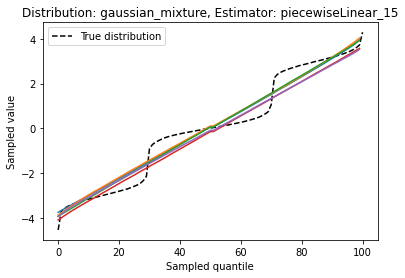

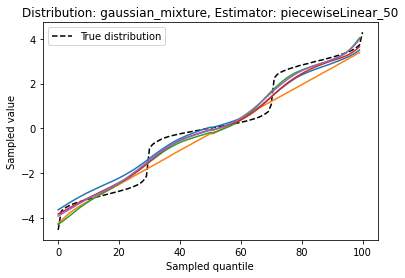

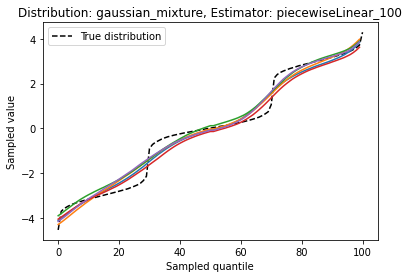

-------------------------------------------------
Distribution: gaussian_mixture, Estimator: piecewiseLinear_15


,mean,amin,amax
MASE,1.035574,1.029070,1.040073
sMAPE,1.656793,1.647387,1.666020
MSIS,6.191181,6.053136,6.265698


,mean,amin,amax
Coverage[0.1],0.116867,0.094667,0.142000
Coverage[0.2],0.258133,0.237000,0.275667
Coverage[0.3],0.304333,0.299333,0.307000
Coverage[0.4],0.338933,0.326667,0.352333
Coverage[0.5],0.496000,0.461333,0.524333
Coverage[0.6],0.648400,0.629667,0.660000
Coverage[0.7],0.694400,0.690667,0.698000
Coverage[0.8],0.736800,0.714667,0.751667
Coverage[0.9],0.877600,0.829667,0.908333
wQuantileLoss[0.1],0.396456,0.394252,0.398760


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: piecewiseLinear_50


,mean,amin,amax
MASE,1.025999,1.015709,1.037774
sMAPE,1.695506,1.647785,1.723330
MSIS,6.400082,6.144928,6.787884


,mean,amin,amax
Coverage[0.1],0.120933,0.102000,0.172000
Coverage[0.2],0.246400,0.233333,0.275667
Coverage[0.3],0.306400,0.302000,0.312333
Coverage[0.4],0.356200,0.321667,0.385000
Coverage[0.5],0.472733,0.439333,0.521333
Coverage[0.6],0.604333,0.579000,0.624000
Coverage[0.7],0.692800,0.686667,0.698667
Coverage[0.8],0.761333,0.705333,0.792333
Coverage[0.9],0.863467,0.788000,0.888667
wQuantileLoss[0.1],0.405176,0.397287,0.422992


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: piecewiseLinear_100


,mean,amin,amax
MASE,1.020534,1.016717,1.024449
sMAPE,1.718612,1.697606,1.736550
MSIS,6.432615,6.255065,6.694735


,mean,amin,amax
Coverage[0.1],0.115067,0.098667,0.146333
Coverage[0.2],0.247600,0.230667,0.265000
Coverage[0.3],0.306600,0.301667,0.309667
Coverage[0.4],0.364533,0.349333,0.384667
Coverage[0.5],0.480667,0.453667,0.531000
Coverage[0.6],0.598667,0.572667,0.635000
Coverage[0.7],0.697467,0.684667,0.709667
Coverage[0.8],0.792667,0.762000,0.819667
Coverage[0.9],0.894467,0.866000,0.929000
wQuantileLoss[0.1],0.407474,0.401020,0.419849


In [41]:
compare_trainings(store_results)